In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from bayes_opt import BayesianOptimization
import numpy as np



In [26]:
#등락으로 분류를 시켰기 때문에 등락 퍼센트는 제거해 주었습니다.다른 변수와 상관성이 너무 높은 속성들은 제거처리 해주었습니다.
df=pd.read_csv(r'C:\DRworks\hynix_short.csv',encoding='cp949', index_col=0)
df=df.drop('H금리대비',axis=1)
df=df.drop('S등락률',axis=1)
df=df.drop('S등락',axis=1)
df=df.drop('H등락',axis=1)
df=df.drop('H등락분류',axis=1)
df=df.drop('H대비',axis=1)
df=df.drop('H시가',axis=1)
df=df.drop('H고가',axis=1)
df=df.drop('H저가',axis=1)
df=df.drop('정기예금환산',axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2670 entries, 2010-07-19 to 2021-05-14
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   S금리대비      2670 non-null   int64  
 1   S종가        2670 non-null   float64
 2   H종가        2670 non-null   float64
 3   H등락률       2670 non-null   float64
 4   H거래량       2670 non-null   int64  
 5   H거래대금      2670 non-null   float64
 6   H시가총액      2670 non-null   float64
 7   H상장주식수     2670 non-null   int64  
 8   원달러환율      2670 non-null   float64
 9   유가종가       2670 non-null   float64
 10  유가오픈       2670 non-null   float64
 11  유가고가       2670 non-null   float64
 12  유가저가       2670 non-null   float64
 13  유가변동률      2670 non-null   float64
 14  한국기준금리     2670 non-null   float64
 15  미국기준금리     2670 non-null   float64
 16  한미기준금리차이   2670 non-null   float64
 17  SOX종가      2670 non-null   float64
 18  SOX변동률     2670 non-null   float64
 19  BTC종가      2670 non-null   float64
 20

In [27]:
#xbbost를 위해 x y 로 데이터 분리 후 dmatrix로 변환 (y=등락정도)
X, y = df.iloc[:,1:],df.iloc[:,0]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
#시기로 분할할 때 데이터
#split = "2012-03-19"
#train = df[:split]
#test= df[split:]

#y_train = train.loc[:,'등락.분류']
#X_train = train.drop('등락.분류', axis=1)
#y_test = test.loc[:,'등락.분류']
#X_test = test.drop('등락.분류', axis=1)


In [28]:
# MAPE Metric
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# 탐색 대상 함수 (XGBRegressor)
def XGB_cv(max_depth,learning_rate, n_estimators, gamma
            ,min_child_weight, subsample
            ,colsample_bytree, silent=True, nthread=-1):
     # 모델 정의
      model = xgb.XGBClassifier(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree, 
                                nthread=nthread
                                )
      # 모델 훈련
      model.fit(X_train, y_train)

      # 예측값 출력
      y_pred= model.predict(X_test)

      # 각종 metric 계산
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)
      mape = mean_absolute_percentage_error(y_test, y_pred)

      # 오차 최적화로 사용할 metric 반환
      return r2



In [29]:
#  bayesian-optimization 라이브러리의 BayesianOptimization 클래스 import
from bayes_opt import BayesianOptimization
import numpy as np

# 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (3, 8),
            'learning_rate': (0.01, 0.2),
            'n_estimators': (50, 1000),
            'gamma': (0, 10),
            'min_child_weight': (0, 4),
            'subsample': (0.5, 1),
            'colsample_bytree' :(0.2, 1)
                }

# Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    

# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

# 찾은 파라미터 값 확인
print(bo.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
[23:37:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  1        | -0.04875  |  0.5336   |  7.203    |  0.01002  |  4.512    |  0.587    |  137.7    |  0.5931   |
[23:37:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when

|  2        | -0.01129  |  0.4764   |  3.968    |  0.1124   |  5.096    |  2.741    |  244.2    |  0.9391   |
[23:37:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


|  3        |  0.04114  |  0.5889   |  3.348    |  0.03273  |  5.076    |  2.31     |  244.9    |  0.5845   |
[23:37:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


|  4        | -0.06373  |  0.8121   |  1.095    |  0.1092   |  6.841    |  2.749    |  176.3    |  0.601    |
[23:37:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


|  5        | -0.01129  |  0.4819   |  4.051    |  0.06254  |  3.815    |  2.075    |  245.3    |  0.8828   |
[23:37:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


|  6        |  0.04864  |  0.6289   |  3.076    |  0.02203  |  5.002    |  2.055    |  245.2    |  0.5173   |
[23:37:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


|  7        | -0.1386   |  0.4239   |  2.046    |  0.1403   |  6.146    |  2.523    |  246.5    |  0.7889   |
[23:37:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


|  8        | -0.01878  |  0.5436   |  2.473    |  0.05616  |  4.399    |  0.4964   |  244.4    |  0.9374   |
[23:37:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


|  9        | -0.01878  |  0.9527   |  3.644    |  0.06398  |  5.693    |  2.693    |  245.0    |  0.5141   |
[23:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


|  10       | -0.003802 |  0.3894   |  2.214    |  0.09706  |  3.934    |  2.961    |  245.2    |  0.992    |
[23:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


|  11       | -0.07871  |  0.4789   |  4.295    |  0.1886   |  5.859    |  1.282    |  245.4    |  0.6299   |
[23:38:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  12       | -0.05624  |  0.7335   |  1.658    |  0.1114   |  4.712    |  1.645    |  243.8    |  0.67     |
{'target': 0.048635757873325414, 'params': {'colsample_bytree': 0.6288605571131781, 'gamma': 3.0762726343420344, 'learning_rate': 0.02203287635294015, 'max_depth': 5.001563951729962, 'min_child_weight': 2.054816351816862, 'n_estimators': 245.196861223931, 'subsample': 0.5172637534181096}}


<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-28-1c9e54b7f079>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [30]:
fit_xgb = xgb.XGBClassifier(max_depth= int( bo.max['params']['max_depth'] ),
                             learning_rate=bo.max['params']['learning_rate'],
                             n_estimators=int(bo.max['params']['n_estimators']),
                             gamma= bo.max['params']['gamma'],
                             min_child_weight=bo.max['params']['min_child_weight'],
                             subsample=bo.max['params']['subsample'],
                             colsample_bytree=bo.max['params']['colsample_bytree'])
model  = fit_xgb.fit(X,y)

C:\phythontemp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

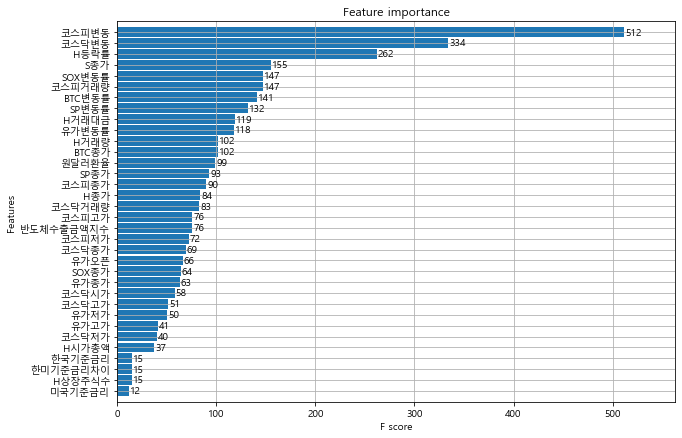

In [31]:
#변수 중요도 그래프
plt.rc('font',family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10,7)
plot_importance(model, height=0.9)

In [32]:
#모델 예측
y_pred = model.predict(X_test)
y_true = y_test

acc = accuracy_score(y_true, y_pred)
con_mat = confusion_matrix(y_true, y_pred)
con_mat
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       265
           1       0.86      0.89      0.87       269

    accuracy                           0.87       534
   macro avg       0.87      0.87      0.87       534
weighted avg       0.87      0.87      0.87       534



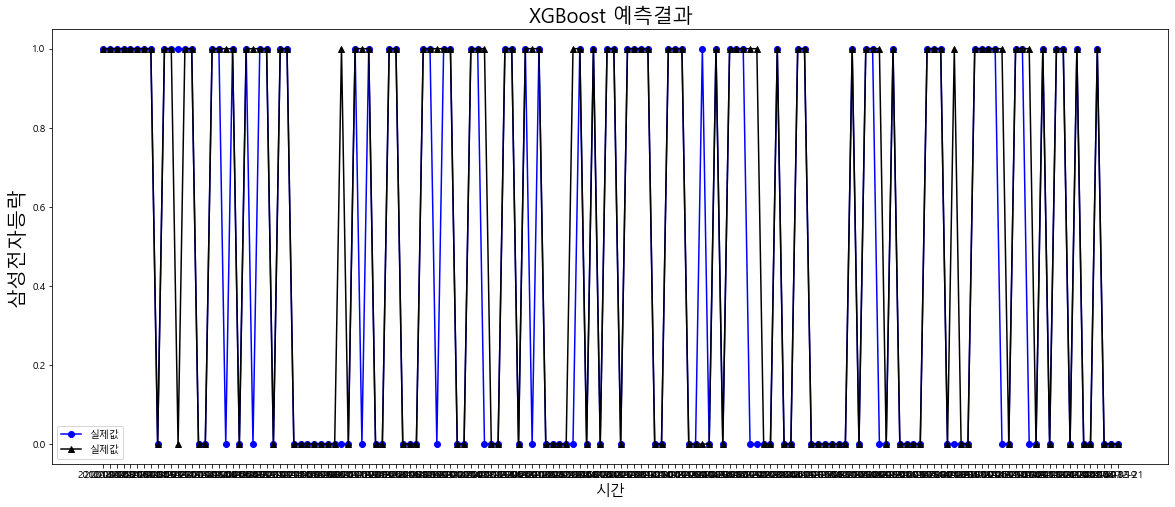

In [33]:
fig =plt.figure( figsize= (20,8))
chart = fig.add_subplot(1,1,1)
chart.plot(y_test[:150],marker='o',color='blue',label='실제값')
chart.plot(y_pred[:150],marker='^',color='black',label='실제값')
chart.set_title('XGBoost 예측결과',size=20)
plt.xlabel('시간',size=15)
plt.ylabel('삼성전자등락',size=20)
plt.legend(loc='best')